In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [2]:
sub1test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-001_Resp_Test.npy")
sub2test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-002_Resp_Test.npy")
sub3test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-003_Resp_Test.npy")
sub4test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-004_Resp_Test.npy")
sub5test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-005_Resp_Test.npy")
print(sub1test.shape)
print(sub2test.shape)
print(sub3test.shape)
print(sub4test.shape)
print(sub5test.shape)

(60784, 4, 600)
(53927, 4, 600)
(64700, 4, 600)
(61899, 4, 600)
(53421, 4, 600)


Concatenate all of the data.

In [3]:
# Each element should be a NumPy array of shape [n_voxels, 4, 60]
subject_list = [sub1test, sub2test, sub3test, sub4test, sub5test]

In [4]:
all_subjects_data = []       # list of [240, n_voxels] per subject
all_genre_labels = []        # genre_labels_named per subject
all_subject_ids = []         # subject index per sample

Create a genre label vector to feed into the UMAP function.

In [5]:
import scipy.io as sio
import numpy as np

# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract the genre label for each of the 60 tracks (6 runs × 10 tracks)
# We use repetition 0 because all 4 reps use the same tracks
genre_labels = []

for run in range(6):  # 6 runs
    for track_position in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_position])  # genre labels are 1-indexed (1–10)
        genre_labels.append(genre_id)

# Step 2: Repeat each genre label 4 times (one for each repetition)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

In [6]:
# Optional: convert genre numbers to names for visualization
genre_names = ['classical', 'electronic', 'folk', 'hiphop', 'jazz',
               'metal', 'pop', 'punk', 'rock', 'world']
genre_labels_named = [genre_names[i - 1] for i in genre_labels_full]

# Preview the result
print(genre_labels_named[:12])  # First 3 tracks (4 reps each)
print(len(genre_labels_named)) 

['world', 'world', 'world', 'world', 'folk', 'folk', 'folk', 'folk', 'classical', 'classical', 'classical', 'classical']
240


Next: reshape data so we use time series vectors for the voxels. 

In [9]:
def preprocess_subject(fmri_data, reps_to_use=3, timepoints_per_track=10):
    """
    Preprocess fMRI data for one subject, without averaging across repetitions.
    
    Args:
        fmri_data: np.array of shape (voxels, repetitions, timepoints)
        reps_to_use: how many repetitions to use (default=3)
        timepoints_per_track: how many timepoints per track (default=10)
        
    Returns:
        X_processed: np.array of shape (60 * reps_to_use, voxels)
    """
    n_voxels = fmri_data.shape[0]
    
    # Reshape the data
    reshaped = np.transpose(
        fmri_data[:, :reps_to_use, :].reshape(n_voxels, reps_to_use, 60, timepoints_per_track),
        (0, 3, 2, 1)
    ).reshape(n_voxels * timepoints_per_track, 60 * reps_to_use)

    X = reshaped.T  # shape: (180 samples, n_voxels * timepoints)

    # Separate voxels and timepoints
    X_voxel_time = X.reshape(60 * reps_to_use, n_voxels, timepoints_per_track)

    # Average across timepoints (but NOT across reps)
    X_mean_time = np.mean(X_voxel_time, axis=2)  # shape: (180 samples, n_voxels)

    return X_mean_time


In [10]:
sub1test_reshaped = np.transpose(sub1test[:, :3, :].reshape(voxels, 3, tracks, timepoints_per_track), [0,3,2,1]).reshape(voxels*timepoints_per_track,tracks*3)

print(sub1test_reshaped.shape)

NameError: name 'voxels' is not defined

PCA dimension reduction so we can stack the voxel info from the different subjects without getting errors about differently sized vectors:

Filter fMRI data so there is less noise by choosing for the voxels that have auditory response. We are looking at the variance of voxel activity, and selecting from there. We will be doing a match test with masking so voxels match up against subject 

In [8]:
# Find shared voxels across all subjects
valid_voxel_masks = []
for fmri_data in subject_list:
    valid_voxels = ~np.isnan(fmri_data).any(axis=(1,2))  # voxel valid if no NaNs across reps/timepoints
    valid_voxel_masks.append(valid_voxels)

# Intersection of all subjects
shared_voxels = np.logical_and.reduce(valid_voxel_masks)

print(f"Number of shared voxels across all subjects: {np.sum(shared_voxels)}")

# Apply the mask immediately to each subject
subject_list_masked = [fmri_data[shared_voxels, :, :] for fmri_data in subject_list]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
#preprocess

all_subjects_data = []
all_genre_labels = []
all_subject_ids = []

# Setup
reps_to_use = 3  # use first 3 reps

for subject_idx, fmri_data in enumerate(subject_list_masked):
    # Preprocess (reshape, average timepoints inside reps, no rep averaging)
    X_mean_time = preprocess_subject(fmri_data, reps_to_use=reps_to_use)  # shape (180, shared_voxels)
    
    all_subjects_data.append(X_mean_time)
    all_genre_labels.extend(genre_labels_named[:60] * 3)  
    all_subject_ids.extend([subject_idx] * 180)

# Stack all subjects
all_subjects_data = np.vstack(all_subjects_data)  # (900, shared_voxels)

print(all_subjects_data.shape)  # should be (900, shared_voxels)


In [ ]:
#select for responsive voxels, 20% with most variance 

# Global voxel variance masking
voxel_variances = np.var(all_subjects_data, axis=0)

threshold = np.percentile(voxel_variances, 80)
high_var_voxels = voxel_variances >= threshold

X_masked = all_subjects_data[:, high_var_voxels]

print(f"Voxels kept after global masking: {np.sum(high_var_voxels)}")
print(f"Masked data shape: {X_masked.shape}")  # (900, selected_voxels)


In [ ]:
#PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
data_matrix = pca.fit_transform(X_masked)

print(data_matrix.shape)  # (900, 50)


Put the above into UMAP:

/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


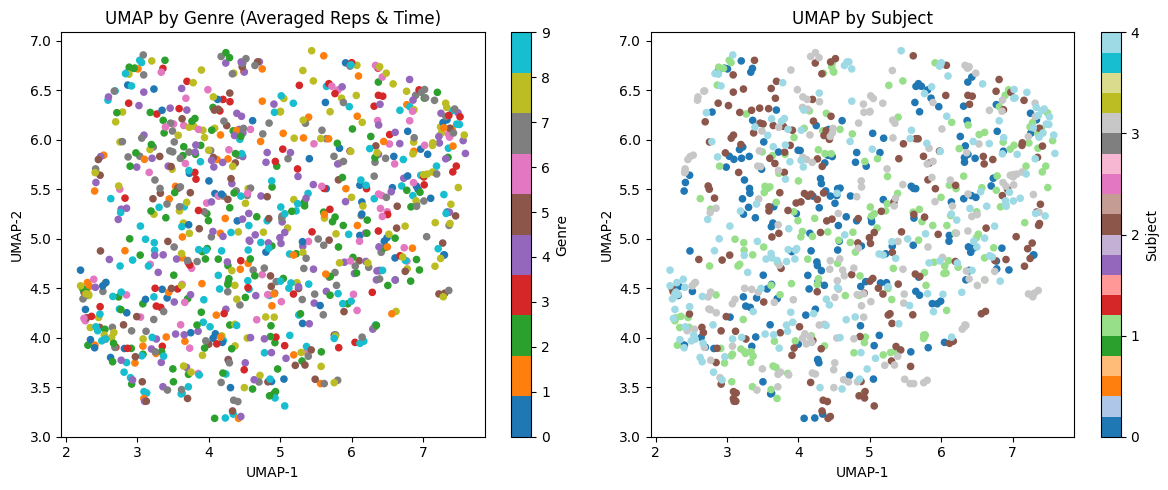

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import umap

# UMAP
reducer = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
embedding = reducer.fit_transform(data_matrix)

# Encode genre labels
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(all_genre_labels)

# Plot
plt.figure(figsize=(12, 5))

# -- Plot by Genre --
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=20)
plt.title("UMAP by Genre")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter1, ticks=range(len(np.unique(genre_encoded))), label='Genre')

# -- Plot by Subject --
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_subject_ids, cmap='tab20', s=20)
plt.title("UMAP by Subject")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter2, ticks=range(len(np.unique(all_subject_ids))), label='Subject')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embedding, genre_encoded)
print(f"Silhouette score by genre: {score:.3f}")
 
#quantify unsupervised cluster quality

Silhouette score by genre: -0.072


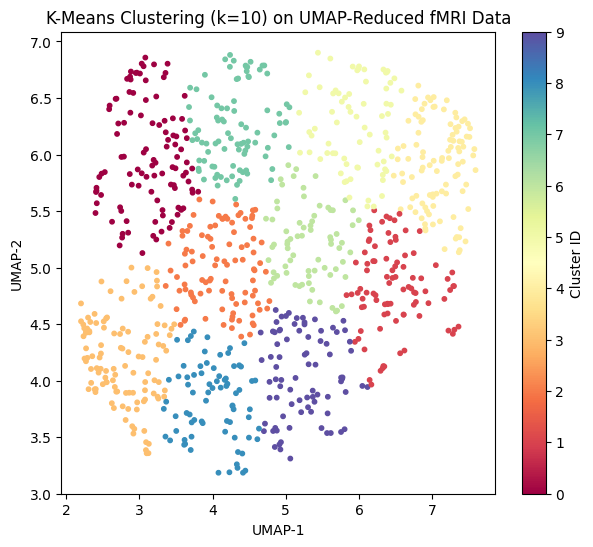

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Run KMeans on your UMAP embedding (2D)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)  # embedding: [n_samples, 2]

# Step 2: Visualize clusters
plt.figure(figsize=(7, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='Spectral', s=10)
plt.title("K-Means Clustering (k=10) on UMAP-Reduced fMRI Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()


In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(genre_labels_named_1200, kmeans_labels)
ami = adjusted_mutual_info_score(genre_labels_named_1200, kmeans_labels)

print(f"ARI: {ari:.3f} | AMI: {ami:.3f}")


NameError: name 'genre_labels_named_1200' is not defined